# Problem 17: Spectral graph partitioning

_Version 1.3_

Changelog:
- 1.3: Added another more informative error message. _[Dec 5, 2019]_
- 1.2: Added more hints and more informative error messages. _[Dec 3, 2019]_
- 1.1: Added more examples; no changes to code or test cells. _[Dec 2, 2019]_
- 1.0: Initial version

In this problem, you'll consider the data mining task of "clustering" a graph. That is, given a graph or network of relationships, can you identify distinct communities within it? This problem assesses your Pandas and Numpy skills.

**Exercises.** There are six exercises, numbered 0-5, worth a total of ten (10) points. However, only Exercises 0-4 require you to write code. If you have done them correctly, then Exercise 5, which consists only of a hidden test cell, should pass when submitted to the autograder.

Regarding dependencies and partial credit:
- Exercise 1 (1 points) depends on a correct Exercise 0 (2 points).
- Exercises 2 (2 points) and 3 (2 points) are independent. Neither depends on Exercises 0 or 1.
- Exercise 4 (2 points) relies on all earlier exercises.
- Exercise 5 (1 point) depends on Exercise 4.

_As always_, it is possible that you will pass Exercises 0-4 but not pass Exercise 5 if there is a subtle bug that the test cells happen not to catch, so be prepared for that possibility!

## Setup

The main modules you'll need are `pandas`, `numpy`, and `scipy`. The rest are auxiliary functions for loading data, plotting results, and test code support. Start by running the following cell.

In [1]:
# Main modules you'll need:
import numpy as np
import scipy as sp
import pandas as pd
from pandas import DataFrame

# Support code for data loading, code testing, and visualization:
import sys
sys.path.insert(0, '.')
from cse6040utils import tibbles_are_equivalent, pandas_df_to_markdown_table, hidden_cell_template_msg, cspy

from matplotlib.pyplot import figure, subplots
%matplotlib inline
from networkx.convert_matrix import from_pandas_edgelist
from networkx.drawing.nx_pylab import draw
from networkx import DiGraph
from networkx.drawing import circular_layout

# Location of input data:
def dataset_path(base_filename):
    return f"{base_filename}"

## Background: Relationship networks and partitioning

Suppose we have data on the following five people, stored in the `nodes` data frame (run the next cell):

In [2]:
nodes = DataFrame({'name': ['alice', 'bob', 'carol', 'dave', 'edith'],
                   'age': [35, 18, 27, 57, 41]})
nodes

,name,age
0,alice,35
1,bob,18
2,carol,27
3,dave,57
4,edith,41


Also suppose we have some information on their relationships, as might be captured in a social network or database of person-to-person transactions. In particular, if some person $a$ follows another person $b$, we say $a$ is the _source_ and $b$ is the _target_. For the people listed above, suppose these relationships are stored in a data frame named `edges` (run this code cell):

In [3]:
edges = DataFrame({'source': ['alice', 'alice', 'dave',  'dave',  'dave',  'bob'],
                   'target': ['dave',  'edith', 'alice', 'edith', 'carol', 'carol']})
edges

,source,target
0,alice,dave
1,alice,edith
2,dave,alice
3,dave,edith
4,dave,carol
5,bob,carol


We can visualize these relationships as a _directed graph_ or _directed network_, where the people are shown as _nodes_ (circles) and the follows-relationships are shown as edges from source to target. Run the next code cell to see the relationships in our example.

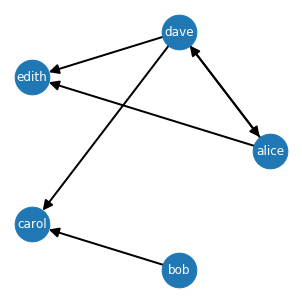

In [4]:
G = from_pandas_edgelist(edges, source='source', target='target', create_using=DiGraph())
figure(figsize=(4, 4))
draw(G, arrows=True, with_labels=True, pos=circular_layout(G),
     node_size=1200, node_color=None, font_color='w',
     width=2, arrowsize=20)

**Observation 0:** From the `edges` data frame, recall that `alice` follows `edith`; therefore, there is an arrow (or edge) pointing from `alice` to `edith`. Since `alice` and `dave` both follow one another, there is a double-headed arrow between them.

**Observation 1:** One can arguably say there are two distinct "groups" in this picture. One group consists of `alice`, `dave`, and `edith`, who have at least 1 one-way follow-relationships among all pairs of them. Similarly, `bob` and `carol` have a one-way relationship between them. However, there is only one relationship between someone from the first group and someone from the second group.

In this problem, we might ask a data mining question, namely, whether we can automatically identify these clusters or groups, given only the known relationships. The method you will implement is known as _spectral graph partitioning_ or _spectral graph clustering_, which is formulated as a linear algebra problem.

## Exercises

**Exercise 0** (2 points -- 0.5 exposed, 1.5 hidden). For our analysis, we won't care whether $a$ follows $b$ or $b$ follows $a$, only that there is some interaction between them. To do so, let's write some code to "symmetrize" the edges. That is, if there is a directed edge from node $a$ to node $b$, then symmetrize will ensure there is also a directed edge $b$ to $a$, unless one already exists. (_Recall Notebook 10!_)

For example, a symmetrized version of the `edges` data frame from above would look like the following:

source|target
---|---
alice|dave
alice|edith
bob|carol
carol|bob
carol|dave
dave|alice
dave|carol
dave|edith
edith|alice
edith|dave

Complete the function, `symmetrize_df(edges)`, below, so that it symmetrizes `edges`. Assume that `edges` is a pandas `DataFrame` with `source` and `target` columns. Your function should return a new pandas `DataFrame` with the edges symmetrized. Your function should also reset the index, so that the output is a proper "tibble."

> **Note 0:** The order of the edges in the output does **not** matter.
>
> **Note 1:** You may assume the input data frame has columns named `'source'` and `'target'`.
>
> **Note 2:** You should drop any duplicate edges. In the example, the edges `'dave'` $\rightarrow$ `'alice'` and `'alice'` $\rightarrow$ `'dave'` already exist in the input. Therefore, observe that they appear in the output, but only once each.
>
> **Note 3:** Your function should work even if there is a "self-edge," i.e., an edge $a \rightarrow a$. The example above does not contain such a case, but the hidden test might check it.

In [5]:
def symmetrize_df(edges):
    assert 'source' in edges.columns
    assert 'target' in edges.columns
    
    # school solution
    from pandas import concat
    edges_transpose = edges.rename(columns={'source': 'target', 'target': 'source'})
    edges_all = concat([edges, edges_transpose], sort=False) \
                .drop_duplicates() \
                .reset_index(drop=True)
    return edges_all
    
# Demo of your function:
symmetrize_df(edges)

,source,target
0,alice,dave
1,alice,edith
2,dave,alice
3,dave,edith
4,dave,carol
5,bob,carol
6,edith,alice
7,edith,dave
8,carol,dave
9,carol,bob


In [6]:
# Test cell: `ex0_symmetrize_df__visible` (1 point)

edges_input = DataFrame({'source': ['alice', 'alice', 'dave',  'dave',  'dave',  'bob'],
                         'target': ['dave',  'edith', 'alice', 'edith', 'carol', 'carol']})
edges_output = symmetrize_df(edges_input)

# The following comment block suggests there is hidden content in this cell, but there really isn't.
###
### AUTOGRADER TEST - DO NOT REMOVE
###

edges_output_soln = pd.read_csv(dataset_path('symmetrize_soln.csv'))
assert tibbles_are_equivalent(edges_output, edges_output_soln), \
       "Your solution does not produce the expected output."

print("\n(Passed.)")


(Passed.)


In [7]:
# Test cell: `ex0_symmetrize_df__hidden`

print(hidden_cell_template_msg())

###
### AUTOGRADER TEST - DO NOT REMOVE
###


This test cell will be replaced with one or more hidden tests.
You will only know the result after submitting to the autograder.
If the autograder times out, then either your solution is highly
inefficient or contains a bug (e.g., an infinite loop). To see
the result of the autograder run, inspect the grading report.



**Exercise 1** (1 point). Given the nodes and edges of a graph as pandas `DataFrames` (i.e., like `nodes` and `edges` above), complete the function below so that it returns a corresponding Scipy sparse matrix in coordinate (COO) format.

That is, your function should do the following:

- The sparse matrix will hold source-to-target relationships. A value of 1.0 (floating-point) in row $i$ and column $j$ will indicate that person $i$ is connected to person $j$.
- Use `nodes.index` to determine the numerical ID (row or column) of each node. For example, Alice's ID is 0, Bob's ID is 1, Carol's ID is 2, and so on. Therefore, in the sparse matrix, Alice will correspond with row 0 and column 0, Bob with row 1 and column 1, and so on.
- Ensure that the dimensions of your sparse matrix are exactly $n \times n$, where $n$ is the largest ID plus one. In the example, Edith has the largest ID of 4; therefore, the sparse matrix should have dimensions of $5 \times 5$.

For example, recall that Alice and Dave are connected by an edge. Therefore, the sparse matrix should have an entry of 1.0 in the (0, 3) position, since Alice's ID is 0 and Dave's is 3.

> **Hint 0:** To help you get started, we've provided a couple lines that (a) determine the output matrix's dimension, `n`; and (b) creates a dictionary, `name_to_id`, which you can use to look up a node's ID given its name.
>
> **Hint 1:** Consider combining Hint 0(b) with the pandas `.replace()` function, which you will recall from an earlier notebook works on either [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) or [`Series`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html) objects.
>
> **Hint 2:** You don't need to handle symmetry in your function. That is, if `edges` was not symmetrized, then there may be a nonzero at location $(i, j)$ but not $(j, i)$. Both should appear only if both are present in `edges`.
>
> **Hint 3:** Recall Notebook 11.

In [8]:
def df_to_coo(nodes, edges):
    """Returns a Scipy coordinate sparse matrix, given an input graph in a data frame representation."""
    assert 'name' in nodes.columns
    assert 'source' in edges.columns
    assert 'target' in edges.columns
    from scipy.sparse import coo_matrix  # Use this to construct your sparse matrix!
    
    n = nodes.index.max() + 1
    name_to_id = dict(zip(nodes['name'], nodes.index))
    
    # school solution
    values = [1.0] * len(edges)
    rows = edges['source'].replace(name_to_id)
    cols = edges['target'].replace(name_to_id)
    return coo_matrix((values, (rows, cols)), shape=(n, n))

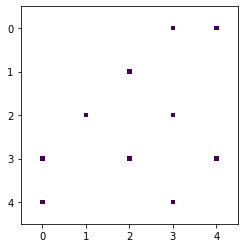

In [9]:
# Demo cell: This function calls your function and draws a picture
# of the resulting sparse matrix, which you can use for debugging.
# In this case, it takes the original (unsymmetrized) `edges`
# data frame, symmetrizes it, and then calls your function. Thus,
# the sparse matrix you see should appear symmetric.

A = df_to_coo(nodes, symmetrize_df(edges))
figure(figsize=(4, 4))
cspy(A, cbar=False)

In [10]:
# Test cell: `ex1_df_to_coo`

def check1(n=5, k=None):
    assert n < 26, "Currently limited to a max dimension of 26"
    from numpy.random import randint
    from numpy import array, vectorize, issubdtype, floating
    def gen_name(c):
        return chr(ord('A') + c)
    nodes = DataFrame({'name': array([gen_name(c) for c in range(n)])})
    name_to_id = dict(zip(nodes['name'], nodes.index))
    if k is None:
        k = randint(0, 5*n)
    if k > 0:
        sources = vectorize(gen_name)(randint(n, size=k))
        targets = vectorize(gen_name)(randint(n, size=k))
    else:
        sources = []
        targets = []
    edges = symmetrize_df(DataFrame({'source': sources, 'target': targets}))
    edges_by_ids = set([(name_to_id[a], name_to_id[b]) for a, b in zip(edges['source'], edges['target'])])
    try:
        A = df_to_coo(nodes, edges)
        assert A.nnz == len(edges_by_ids), f"Expected {len(edges_by_ids)} edges, but you produced {A.nnz}."
        assert issubdtype(A.dtype, floating), f"Value type is `{A.dtype}`, which is incorrect."
        A_edge_set = set()
        for i, j, v in zip(A.row, A.col, A.data):
            assert v == 1.0, f"All values should equal 1.0, but you have {v} at position ({i}, {j})."
            A_edge_set |= {(i, j)}
        assert edges_by_ids == A_edge_set, \
               f"Your matrix has incorrect edges in it:\n" \
               f"  * Expected: {edges_by_ids}\n" \
               f"  * You:      {A_edge_set}\n"
    except:
        print("=== Failing test case ===")
        print("* Nodes:")
        display(nodes)
        print("* Edges:")
        display(edges)
        raise

for _ in range(10):
    check1()
    
# Check empty test case
check1(k=0)

print("(Passed.)")

(Passed.)


**Exercise 2** (2 points). Suppose you are given a vector (1-D Numpy array). Write a function that returns a pair of 1-D Numpy arrays: one containing the positions (i.e., indices or locations) of all positive entries (strictly greater than zero), and one containing all remaining positions (less than or equal to zero).

For example, if one runs
```python
x = np.array([1, -1, -2, 2, -3, 3, 4, -4, -5, 5])
k_gtz, k_lez = partition_inds_by_sign(x)
```
then
```python
assert (k_gtz == np.array([0, 3, 5, 6, 9])).all()  # Positive positions (> 0)
assert (k_lez == np.array([1, 2, 4, 7, 8])).all()  # Non-positive (<= 0)
```

> **Note 0:** Your function must return a pair of 1-D Numpy arrays. Each 1-D array must be truly 1-D. That is, it must have an `.ndim=1`; a 2-D array where one of the dimensions equals 1 will not be considered correct.
>
> **Note 1:** Your function should not be too slow. The test cell first checks a bunch of small examples for correctness; it then runs a larger test for efficiency. As usual, the autograder must complete both for you to get any credit.
>
> **Hint:** See [`numpy.where`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html). If you use it, pay close attention to its return value to ensure you extract the right information from it.

In [11]:
def partition_inds_by_sign(x):
    # school solution 
    from numpy import where
    K_pos = where(x > 0)[0]
    K_neg = where(x <= 0)[0]
    return K_pos, K_neg

# Demo:
x = np.array([1, -1, -2, 2, -3, 3, 4, -4, -5, 5])
k_gtz, k_lez = partition_inds_by_sign(x)
print(f"x[{k_gtz}] == {x[k_gtz]}") # Correct output: `x[[0 3 5 6 9]] == [1 2 3 4 5]`
print(f"x[{k_lez}] == {x[k_lez]}") # Correct output: `x[[1 2 4 7 8]] == [-1 -2 -3 -4 -5]`

x[[0 3 5 6 9]] == [1 2 3 4 5]
x[[1 2 4 7 8]] == [-1 -2 -3 -4 -5]


In [12]:
# Test cell: `ex2_partition_inds_by_sign`

def check2(n=8):
    from random import randrange
    from numpy import array, issubdtype, integer, ndarray
    x = []
    kp = []
    kn = []
    for i in range(n):
        x.append(randrange(-10, 10))
        (kp if x[-1] > 0 else kn).append(i)
    x, kp, kn = array(x), array(kp, dtype=int), array(kn, dtype=int)
    try:
        k_gtz, k_lez = partition_inds_by_sign(x)
        assert isinstance(k_gtz, ndarray) and isinstance(k_lez, ndarray), \
               "You did not return Numpy arrays."
        assert issubdtype(k_gtz.dtype, integer) and issubdtype(k_lez.dtype, integer), \
               f"Both Numpy element types must be integers (yours are {k_gtz.dtype} and {k_lez.dtype})."
        assert (k_gtz == kp).all(), "Indices of positive values is incorrect."
        assert (k_lez == kn).all(), "Indices of non-positive values is incorrect."
    except:
        print("=== Error on test case! ===")
        print(f"Input: {x}")
        print(f"Your solution: {k_gtz}, {k_lez}")
        print(f"True solution: {kp}, {kn}")
        assert False, "Please double-check your approach on this test case."
    
print("Checking for correctness on small inputs...")
for _ in range(100):
    check2()
    
print("Checking for efficiency on a larger input...")
check2(2000000)
    
print("(Passed.)")

Checking for correctness on small inputs...
Checking for efficiency on a larger input...
(Passed.)


**Permutation vectors.** A permutation vector is a list of indices that corresponds to a rearrangement of the elements of another vector.

For example, above we determined where the positive elements are and where the non-positive elements are. If we concatenate these into a single vector, the result is a permutation vector that can be used to place all the positive elements first, followed by the negative elements. For example:

In [13]:
print(f"x == {x}")
k = np.concatenate((k_gtz, k_lez))
print(f"k == {k}")
y = x[k] # permute!
print(f"y = x[k] == {y}") # elements rearranged

x == [ 1 -1 -2  2 -3  3  4 -4 -5  5]
k == [0 3 5 6 9 1 2 4 7 8]
y = x[k] == [ 1  2  3  4  5 -1 -2 -3 -4 -5]


**Inverse permutations.** It's sometimes useful to _invert_ a permutation. In the previous example, suppose you are given `y` and want to recover `x`. The _inverse permutation vector_, `k_inv`, produces `x = y[k_inv]`. In the next exercise, you will write code to compute `k_inv`, given `k`. As a hint about how to do so, here is a picture of the process of computing `y = x[k]` and, later, `x = y[k_inv]`:

<img src="perm-example.png" alt="Example: Permutations and their inverses" style="width: 512px;"/>

**Exercise 3** (2 points). Complete the function `k_inv = invert_perm(k)`, below, so that returns the inverse of the permutation vector `k`. For the preceding example:
```python
    invert_perm(k) == np.array([0, 5, 6, 1, 7, 2, 3, 8, 9, 4])
```
If it would be helpful, here is a picture of your task, namely, to calculate `k_inv` given `k`:

<img src="k-vs-k_inv.png" alt="Example: Permutations and their inverses (2)" style="width: 512px;"/>

In [14]:
def invert_perm(k):
    from numpy import ndarray, issubdtype, integer
    assert isinstance(k, ndarray), "Input permutation should be a Numpy array."
    assert issubdtype(k.dtype, integer), "Input permutation should have integer elements."
    assert (k >= 0).all(), "Input permutation should contain positive values."
    
    # school solution
    from numpy import empty, arange
    k_inv = empty(len(k), dtype=int)
    k_inv[k] = arange(len(k))    
    return k_inv
    # Cute alternative: https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy

# Demo
k_inv = invert_perm(k)
y = x[k]
print(f"x == {x}")
print(f"k == {k}")
print(f"y = x[k] == {y}")
print(f"k_inv == {k_inv}")
print(f"y[k_inv] == {y[k_inv]}")   # If all goes well, should equal `x`
assert (y[k_inv] == x).all(), "Demo failed!"

x == [ 1 -1 -2  2 -3  3  4 -4 -5  5]
k == [0 3 5 6 9 1 2 4 7 8]
y = x[k] == [ 1  2  3  4  5 -1 -2 -3 -4 -5]
k_inv == [0 5 6 1 7 2 3 8 9 4]
y[k_inv] == [ 1 -1 -2  2 -3  3  4 -4 -5  5]


In [15]:
# Test cell: `ex3_invert_perm`

def check3(n=8):
    from numpy import arange, ndarray, issubdtype, integer
    from numpy.random import permutation
    try:
        x = arange(n)
        p = permutation(n)
        p_inv = invert_perm(p)
        assert isinstance(p_inv, ndarray) and (p_inv.ndim == 1), "You did not return a 1-D Numpy array."
        assert issubdtype(p_inv.dtype, integer), f"Numpy element type must be integer, not {p_inv.dtype}."
        y = x[p]
        z = y[p_inv]
        assert (x == z).all()
    except:
        print("=== Failed test case ===")
        print(f"Input: x == {x}")
        print(f"A random permutation: p == {p}")
        print(f"Permuted `x`: y == x[p] == {y}")
        print(f"Your inverse permutation: p_inv == {p_inv}")
        print(f"Result of y[p_inv] should be `x`, and yours is {z}")
        raise
        
for _ in range(100):
    check3()
    
print("(Passed.)")

(Passed.)


## Spectral partitioning (or clustering)

With the preceding building blocks, you are now ready to implement a technique known as _spectral graph partitioning_.

Without going into too many details, the technique proceeds as follows:

1. Form a special matrix called the _graph Laplacian_. This is a matrix $L = D - A$, where $A$ is a symmetrized matrix of relationships like what you worked with above, and $D$ is a diagonal matrix consisting of the degrees of every node. (Recall from an earlier notebook that the degree of a node is the number of edges that touch it.)
2. Compute the _second smallest eigenvalue_ (in magnitude) and its corresponding eigenvector. This eigenvector is known as the _Fiedler vector_.
3. Use the signs of the components of the Fiedler vector to identify two groups of nodes. That is, form one group from the components with positive sign, and the other from components with non-positive sign.

We will provide you with code to perform steps 1 and 2. In Exercise 4 below, you need to write code to carry out step 3.

**Calculating the Fiedler vector.** Here is the code to compute the Fiedler vector, given a (symmetrized) matrix of relationships, $A$. In particular, the function `calc_fiedler_vector(A)` returns the Fiedler vector. The cell below also prints the Fiedler vector for the example network from above.

In [16]:
def calc_degrees_matrix(A):
    from scipy.sparse import spdiags
    n = min(A.shape)
    return spdiags(A.sum(axis=1).reshape(n), diags=0, m=A.shape[0], n=A.shape[1])

def calc_fiedler_vector(A):
    from scipy.sparse.linalg import eigsh
    D = calc_degrees_matrix(A)
    L = D - A # Form Laplacian
    _, V = eigsh(L, k=2, which='SM') # Determine 2nd smallest eigenpair
    return V[:, 1]

# Demo:
v = calc_fiedler_vector(A)
print(v)

[ 0.41931948 -0.702415   -0.3379981   0.20177414  0.41931948]


Suppose we use the Fiedler vector to create groups, partitioning by sign using your code from Exercise 2. Observe what happens.

In [17]:
k_gtz, k_lez = partition_inds_by_sign(v)

print("=== Group 0 ===")
display(nodes.loc[k_gtz])

print("\n=== Group 1 ===")
display(nodes.loc[k_lez])

=== Group 0 ===


,name,age
0,alice,35
3,dave,57
4,edith,41



=== Group 1 ===


,name,age
1,bob,18
2,carol,27


Notice that `alice`, `dave`, and `edith` appear in one group, and `bob` and `carol` in the other! That corresponds with what we said was our intuitive idea of the "natural" clusters in the network.

**Hint for the next (and last) exercise.** Given a coordinate sparse matrix, `A`, recall that you can access its row indices, column indices, and values using the following attributes of `A` (run the code cell).

In [18]:
print("COO row indices:", A.row)
print("COO column indices:", A.col)
print("COO values:", A.data)

COO row indices: [0 0 3 3 3 1 4 4 2 2]
COO column indices: [3 4 0 4 2 2 0 3 3 1]
COO values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Exercise 4** (2 points). Given a coordinate sparse matrix `A` and a Fiedler vector `v`, complete the function `reorder_by_fiedler(A, v)` below so that it does the following:

- Uses the Fiedler vector `v` to create a permutation vector that groups positive values first followed by non-positive values.
- Creates a new coordinate sparse matrix, `A_perm`, which is `A` with its rows and columns permuted according to the permutation vector.

Permuting the rows and columns means simultaneously reordering them according to a permutation vector. You can do so by simply "relabeling" the indices in just the right way. In particular, let's call the permutation vector `k`. Then, in the permuted matrix `A_perm`, the row index that was `k[i]` in `A` should become row index `i` in `A_perm`. Similarly, any column index `k[j]` in `A` should become column index `j` in `A_perm`.

For example, suppose the Fiedler vector of the example matrix `A` above had `[0, 3, 4]` as positive components and `[1, 2]` as non-positive, meaning the concatenated permutation vector is `[0, 3, 4, 1, 2]`. Then, reading the permutation vector from left-to-right, the row index that was 0 in `A` should remain 0 in the permuted matrix `A_perm`; the row index that was 3 in `A` should be changed to 1 in `A_perm`; the row index that was 4 in `A` should become 2 in `A_perm`; the row index that was 1 should become 3; and the final row index of 2 should become 4. An identical relabeling should be applied to the column indices. A spy plot of the original matrix and its reordered version are as follows:

<img src="example_A_before_and_after_perm.png" alt="Example of a matrix symmetrically reordered by the permutation vector `[0, 3, 4, 1, 2]`." style="width: 640px;"/>

Notice how the nonzeros are grouped differently, with some clustering happening along the diagonal blocks after permutation. That's a visual signal that we've identified some clusters.

> **Note:** The eigensolver used to compute the Fiedler vector can sometimes "flip" the signs. The results are essentially the same, but it may mean that the permuted result will have the diagonal blocks you see above reversed.
>
> **Hint:** The example you see above is tricky, because it turns out the permutation vector `[0, 3, 4, 1, 2]` is its own inverse! In developing your solution, **you'll need to think carefully about whether you should use a permutation vector, its inverse, both, or neither.**

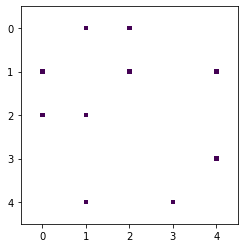

In [19]:
def reorder_by_fiedler(A, v):
    from scipy.sparse import coo_matrix
    assert isinstance(A, type(coo_matrix((1, 1))))
    
    # school solution
    k_gtz, k_lez = partition_inds_by_sign(v)
    k = np.concatenate((k_gtz, k_lez))
    k_inv = invert_perm(k)
    rows_perm = k_inv[A.row]
    cols_perm = k_inv[A.col]
    return coo_matrix((A.data, (rows_perm, cols_perm)), shape=A.shape)
    
A_perm = reorder_by_fiedler(A, v)
figure(figsize=(4, 4))
cspy(A_perm, cbar=False)

In [20]:
# Test cell: `ex4_reorder_by_fiedler`

def check4(n=8):
    from random import randrange
    from numpy import array, arange, where
    import scipy.sparse as sparse
    v = []
    kp = []
    kn = []
    for i in range(n):
        v.append(randrange(-10, 10))
        (kp if v[-1] > 0 else kn).append(i)
    v, p = array(v), array(kp + kn)
    A = sparse.random(n, n, 0.25)
    A.data = arange(1, len(A.data)+1)
    try:
        A_perm = reorder_by_fiedler(A, v)
        assert isinstance(A_perm, type(A)), \
               f"You returned an object of type {type(A_perm)}, not {type(A)}."
        assert A.shape == A_perm.shape, \
               f"You returned a sparse matrix with dimensions {A_perm.shape} instead of {A.shape}."
        assert A.nnz == A_perm.nnz, \
               f"Your result has {A_perm.nnz} nonzeros instead of {A.nnz}."
        for i, j, a_perm_i_j in zip(A_perm.row, A_perm.col, A_perm.data):
            i0, j0 = p[i], p[j]
            k0 = where((A.row == i0) & (A.col == j0))[0]
            a_i0_j0 = A.data[k0]
            assert a_perm_i_j == a_i0_j0, \
                   f"Entry ({i}, {j}) of your solution does not appear to be correct."
    except:
        print("=== Error on test case! ===")
        print(f"Input matrix:")
        print(f"* rows = {A.row}")
        print(f"* cols = {A.col}")
        print(f"* vals = {A.data}")
        print(f"Fiedler vector: {v}")
        print(f"Permutation: {p}")
        assert False, "Please double-check your approach on this test case."
    
print("Checking for correctness...")
for _ in range(100):
    check4()
    
print("(Passed.)")

Checking for correctness...
(Passed.)


## Application: Political blogs analysis

As a final step, let's try this method on a real dataset. If you already did the above exercises correctly, you do not have to write more code. However, there is one more test cell that must pass to get full points on this problem; see Exercise 5, below.

**Political blogs dataset.** The dataset consists of political blogs and their links to one another. Let's load these data and take a look.

In [21]:
blog_nodes = pd.read_csv(dataset_path('polblogs3_nodes.csv'))
blog_edges = pd.read_csv(dataset_path('polblogs3_edges.csv'))

display(blog_nodes.head())
print(f"==> The `blog_nodes` data frame lists {len(blog_nodes)} blog sites.")
display(blog_edges.head())
print(f"==> The `blog_edges` data frame contains {len(blog_edges)} directed links" \
      f"among sites (~ {len(blog_edges)/len(blog_nodes):.1f} links/site).")

,name,pol
0,kevincourser.blogspot.com,1
1,theleftcoaster.com,-1
2,kicktheleftist.blogspot.com,-1
3,madanthony.org,1
4,karmicsoup.blogspot.com,-1


==> The `blog_nodes` data frame lists 754 blog sites.


,source,target
0,kevincourser.blogspot.com,littlegreenfootballs.com/weblog
1,kevincourser.blogspot.com,drudgereport.com
2,theleftcoaster.com,warandpiece.com
3,theleftcoaster.com,bartcop.com
4,theleftcoaster.com,prospect.org/weblog


==> The `blog_edges` data frame contains 25042 directed linksamong sites (~ 33.2 links/site).



The `blog_nodes` data frame above has a column named `'pol'`, which is the political affiliation of the blog: a `+1` means a conservative (politically right-leaning) site, and a `-1` means a liberal (left-leaning) site.

Let's see what happens if we partition the graph corresponding to these sites and their links to one another.

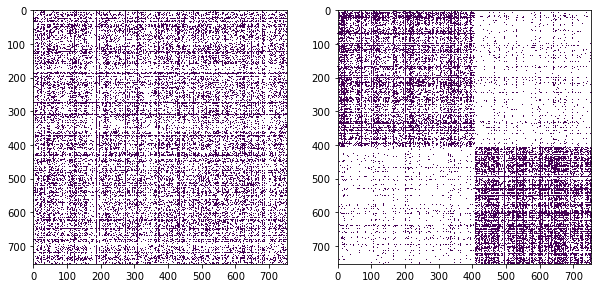

In [22]:
A_blogs = df_to_coo(blog_nodes, blog_edges)
v_blogs = calc_fiedler_vector(A_blogs)
A_blogs_perm = reorder_by_fiedler(A_blogs, v_blogs)

f, (ax1, ax2) = subplots(1, 2, figsize=(10, 5))
cspy(A_blogs, ax=ax1, cbar=False, s=1)
cspy(A_blogs_perm, ax=ax2, cbar=False, s=1)

If everything is working, you should see two spy plots. The left-hand plot does not appear to have much structure; however, the right-hand plot, which is the same graph permuted by the Fiedler vector, should have some strong block-diagonal structure, indicating the presence of clusters.

Indeed, let's see which sites correspond to positive entries of the Fiedler vector, and which correspond to negative entries.

In [23]:
kp_blogs, kn_blogs = partition_inds_by_sign(v_blogs)
len(kp_blogs), len(kn_blogs)

(408, 346)

The next cell displays a random sample of the two groups:

In [24]:
display(blog_nodes.loc[kp_blogs].sample(10))
display(blog_nodes.loc[kn_blogs].sample(10))

,name,pol
448,stix1972.blogspot.com,1
382,alamonation.blogspot.com,1
222,americanwarmonger.blogspot.com,1
45,belmontclub.blogspot.com,1
532,borgardblog.blogspot.com,1
223,writingcompany.blogs.com/this_isnt_writing_its...,1
86,slingsnarrows.erudite-absurdity.com,1
510,americanfuture.typepad.com,1
596,kimdutoit.com/dr/weblog.php,1
60,eeg3.com,1


,name,pol
511,michaelberube.com,-1
675,burntorangereport.com,-1
377,mathewgross.com/blog,-1
118,theyetimn.blogspot.com,-1
689,americansforbayh.blogspot.com,-1
152,angrybear.blogspot.com,-1
182,theangryliberal.blogspot.com,-1
281,jewssansfrontieres.blogspot.com,-1
366,xnerg.blogspot.com,-1
5,americablog.org,-1


You should see that one of the samples has mostly +1 political affiliations, whereas the other has mostly -1 affiliations. Indeed, if we calculate the statistics on the `pol` column of the two groups, you can confirm this finding:

In [25]:
display(blog_nodes.loc[kp_blogs].describe())
display(blog_nodes.loc[kn_blogs].describe())

,pol
count,408.000000
mean,0.970588
std,0.241041
min,-1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


,pol
count,346.000000
mean,-0.919075
std,0.394653
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,1.000000


You should see the mean and median values near +1 in one group and -1 in the other.

**Exercise 5** (1 point). You do not need to write any more code. This "exercise" is simply an end-to-end test of all the code you wrote in Exercises 0-4. If those are working correctly and are "efficient enough," then the test hidden cell that appears immediately below should pass the autograder.

In [26]:
# Test cell: `ex5_end_to_end_check`

print(hidden_cell_template_msg())

###
### AUTOGRADER TEST - DO NOT REMOVE
###


This test cell will be replaced with one or more hidden tests.
You will only know the result after submitting to the autograder.
If the autograder times out, then either your solution is highly
inefficient or contains a bug (e.g., an infinite loop). To see
the result of the autograder run, inspect the grading report.



**Fin!** You’ve reached the end of this part. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. If the autograder seems to fail, be sure to inspect the grading report for more information. Good luck!

> **Reference:** The US political blogs dataset used in this problem were recorded in 2005 by L. A. Adamic and N. Glance, "_The political blogosphere and the 2004 US Election_," in the Proceedings of the WWW-2005 Workshop on the Weblogging Ecosystem (2005). The full dataset is available [here](http://www-personal.umich.edu/~mejn/netdata/), but in this problem, we use a subset of that data.